# Classification of the CIFAR-10 dataset

The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) provides 60000 32x32-pixel images, classified into 10 categories.  The figure below provides a random sample of some images in each category.

![images.png](images.png)

During this session, you will learn how to build a Convolutional Neural Network (CNN), which (when trained) will be able to automatically classify new images into one of these categories.  We will make use of the [Keras library](https://www.tensorflow.org/guide/keras) which provides a high-level interface to TensorFlow. Begin by importing the necessary modules.

In [1]:
import os
import time
import datetime
from tqdm import tqdm_notebook

import numpy as np
import pandas
import matplotlib.pyplot as plt
from sklearn import metrics

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from keras.layers import Dense, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, BatchNormalization
from keras.optimizers import SGD
from keras.datasets import cifar10
from keras.utils.np_utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import EarlyStopping

Using Theano backend.


# Table of content

[1. A first look at the data set](#dataset)<br>

[2. A first naive model](#first_model)<br>

[3. Convolutional Neural Networks](#cnn)<br>
- [3.1 Create your first CNN](#first_cnn)<br>
- [3.2 Influence of parameters on the performance](#cnn_parameters)<br>
- [3.3 Studying predictions](#results)<br>

[4. Pretrained Networks](#pretrained_cnn)<br>


<a id='dataset'></a>
# 1 - A first look at the data set

**1) Download the dataset. See [`keras.datasets`](https://keras.io/datasets/) for how to download the data.  Note that the dataset is already divided into a training set of 50000 images, and a test set of 10000.**

In [60]:


from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()



**2) Check the shape of images and targets.**

In [6]:


print("The shape of the images is", np.shape(x_train[0]))
print("The shape of the labels is", np.shape(y_train[0]))



The shape of the images is (32, 32, 3)
The shape of the labels is (1,)


**3) Create a list of labels corresponding to the 10 categories.  This will be used to convert the 0-9 digits in the target arrays to string labels. The categories are labeled as follows**
  0. airplane
  1. automobile
  2. bird
  3. cat
  4. deer
  5. dog
  6. frog
  7. horse
  8. ship
  9. truck


In [7]:

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


**4) Normalize images from [0,255] to be [0,1] (normalizing usually improves model training).**

In [8]:


# Normalize the data
x_train = x_train.astype('float32') / 255
x_test  = x_test.astype('float32') / 255


**5) Convert the target arrays to one-hot encodings.  Hint: checkout the [`keras.utils.to_categorical()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical)**

In [9]:

from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train, 10)
y_test  = to_categorical(y_test, 10)

#

**6) Visualize some images in each category using the `imshow()` function in `matplotlib.pyplot`.  Can you recreate the figure at the top?  Hint: the top figure was created using the first 8 images belonging to each category in the training data.**

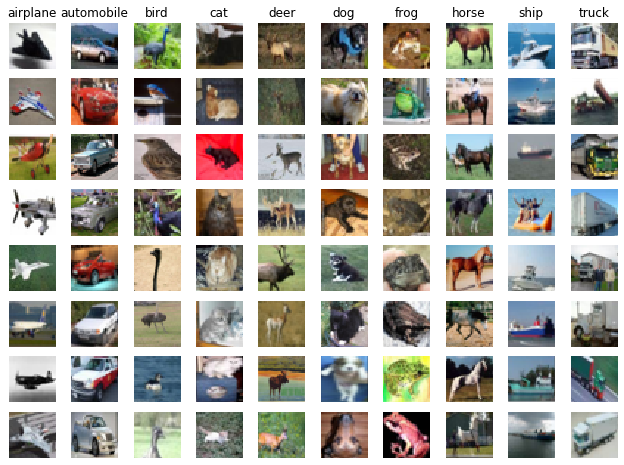

In [10]:


n, images, categories, labels = 8, x_train, y_train, labels 

f, axes = plt.subplots(n, 10, figsize=(11,8))
    
for i in range(10):
    count = 0
    j = 0
    while count < n and j < 50000:
        if categories[j][i] == 1:
            axes[count,i].imshow(images[j,:,:,:])
            axes[count,i].axis('off')
            if count == 0:
                axes[count,i].set_title(labels[i])
            count += 1
        j += 1
plt.show()


The following code summarizes the previous operations. 

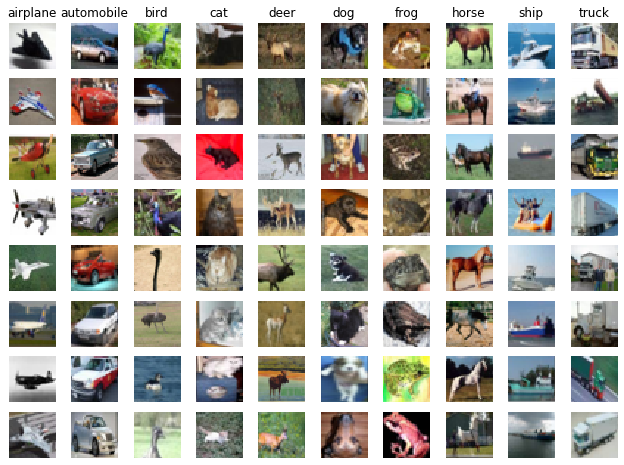

In [2]:
 

def load_cifar_data():
    """
    Loads the CIFAR-10 dataset using Keras and preprocess for training.
    """
    # Download / Load the datasets
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    
    # Normalize the data
    y_train = to_categorical(y_train, 10)
    y_test  = to_categorical(y_test, 10)
    x_train = x_train.astype('float32') / 255
    x_test  = x_test.astype('float32') / 255
    
    # Label vector
    labels = [
        'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 
        'frog', 'horse', 'ship', 'truck'
    ]
    
    return x_train, y_train, x_test, y_test, labels

x_train, y_train, x_test, y_test, labels = load_cifar_data()

def show_first_n_images_in_categories(n, images, categories, labels, file_name=None):
    """Plots the first n images in each category from the image data."""
    f, axes = plt.subplots(n, 10, figsize=(11,8))
    
    for i in range(10):
        count = 0
        j = 0
        while count < n and j < 50000:
            if categories[j][i] == 1:
                axes[count,i].imshow(images[j,:,:,:])
                axes[count,i].axis('off')
                if count == 0:
                    axes[count,i].set_title(labels[i])
                count += 1
            j += 1

    if file_name:
        plt.savefig(file_name)
    else:
        plt.show()

show_first_n_images_in_categories(8, x_train, y_train, labels, file_name = None)

#Reducing the size of the training set

#x_train = x_train[range(5000),:,:,:]
#y_train = y_train[range(5000)]

#x_test = x_train[range(500),:,:,:]
#y_test = y_train[range(500)]



<a id='first_model'></a>

# 2 - First naive model

In order to better understand the importance of CNNs, it is instructive to first see how well a naive dense network performs on the dataset.

**7) Create a sequential model with 4 `Dense` hidden layers of 2048, 1024, 512, and 256 nodes each, with ReLU activation, and a linear output layer of 10 nodes. Compile the model with a `categorical_crossentropy` loss, using the SGD optimizer, including the `accuracy` metric. 
Note that you will need to use the `Flatten` layer first in order to convert the 3D (x, y, rgb) image data into 1D.**

In [3]:
def dense_model(input_shape, num_classes):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(2048, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, input_shape=(input_shape,), activation='relu'))
    model.add(Dense(num_classes, activation='linear'))

    sgd = SGD(lr=0.1, decay=1.0e-6)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model


**8) Compute by hand the total number of trainable parameters (weights and biases) in the model.**

The inputs are of size 
$$ 
32 \times 32 \times 3 = 3072.
$$

There are connections between each neuron of two consecutive layers, which correspond to a number of weights equal to 
$$ 3072 \times 2048 + 2048 \times 1024 + 1024 \times 512 + 512 \times 256 + 256 \times 10 
= 9046528 $$

The number of bias is equal to the number of intermediary neurons plus the number of neurons of the output layer: 
$$ 2048 + 1024 + 512 + 256 + 10 = 3850.$$

The total number of parameters is then $ 9046528 + 3850 = 9050378$.

**9) Use the `summary()` function on model to get a text summary of the model.  Did you compute the number of parameters correctly?**

In [4]:
model = dense_model(x_train[0].shape, 10)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              6293504   
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                2570      
Total params: 9,050,378
Trainable params: 9,050,378
Non-trainable params: 0
____________________________________________

**10) Train the model for 10 epochs, with a batch size of 32 (you may also use early stopping). What is the model performance?**

In [5]:


def train_model(model, x, y, batch_size=32, epochs=10, file_name=None):
    """
    Trains the model on the given data.
    """
    
    stop_early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=2, mode='auto')
    
    ret = model.fit(x, y, batch_size=batch_size, epochs=epochs, validation_split=0.2, shuffle=True, 
                    callbacks=[stop_early], verbose = 2)
    
    if file_name:
        model.save(file_name)
    
    return ret

ret = train_model(model, x_train, y_train)

#You can use ret.history['val_loss'] or ret.history['val_accuracy'] to access the list of 
#loss/accuracy for each epoch


Train on 40000 samples, validate on 10000 samples
Epoch 1/10
 - 62s - loss: 2.4931 - accuracy: 0.0845 - val_loss: 2.6012 - val_accuracy: 0.0980
Epoch 2/10
 - 62s - loss: 2.4598 - accuracy: 0.0996 - val_loss: 2.3713 - val_accuracy: 0.1022
Epoch 3/10
 - 62s - loss: 2.3362 - accuracy: 0.0997 - val_loss: 2.3131 - val_accuracy: 0.1022
Epoch 4/10
 - 62s - loss: 2.3078 - accuracy: 0.1001 - val_loss: 2.3035 - val_accuracy: 0.1022


**11) Plot several images with their predictions. Any comment?**

The accuracy on the test set is 0.1
The prediction for this image is truck but it is in reality a frog
[    0.     0.     0.     0.     0.     0.     0.     0.     0. 10000.]


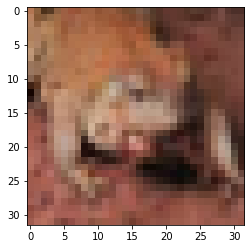

In [6]:

#You can use ret.history['val_loss'] or ret.history['val_accuracy'] to access the list of 
#loss/accuracy for each epoch

#Compute the predictions
y_pred = model.predict_classes(x_test)
y_pred = to_categorical(y_pred, 10)

# Compute the accuracy
print("The accuracy on the test set is", metrics.accuracy_score(y_test, y_pred) )

# Plot image number j 
j= 5
plt.imshow(x_test[j])
print("The prediction for this image is", labels[np.argmax(y_pred[j])], "but it is in reality a", labels[np.argmax(y_test[j])])

#Here is the distribution of predictions : if an element is close to one, 
#the algorithm almost always predict this category

print(y_pred.sum(axis=0))


<a id='cnn'></a>

# 3 - Convolutional Neural Network
 

Convolutional neural networks allow us to do drastically better on this dataset (and many image classification problems in general).  In this task, you will build your first convolutional network and see how it performs during training.

<a id='first_cnn'></a>
## 3.1 - Create your first CNN

**12) Create a new model with the following layers (use the same optimizer and loss as above)**
  - 3x3 2D convolution with zero padding (same), 32 filters
  - ReLU activation
  - 3,3 2D convolution, no padding, 32 filters
  - ReLU activation
  - Max pooling with size (2,2)
  - 3x3 2D convolution, no padding, 64 filters
  - ReLU activation
  - 3x3 2D convolution, no padding, 64 filters
  - ReLU activation
  - Max pooling with size (2,2)
  - Flatten
  - Dense layer with 512 nodes, ReLU activation
  - Softmax output layer with 10 nodes

In [7]:
def cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32,(3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
  
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
 
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    sgd = SGD(lr=0.1, decay=1.0e-6)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

# Create the model
model = cnn_model(x_train.shape[1:], 10)


**13) Compute by hand the number of trainable parameters in this network.  Are there more or less than the more simple dense network?  Why?  Confirm with `summary()`.**

Number of parameters of the first convolutional layer: 
$$
(3 \times 3 \times 3+1) \times 32 = 896
$$
Number of parameters of the second convolutional layer: 
$$
(3 \times 3 \times 32+1) \times 32 = 9248
$$
Number of parameters of the third convolutional layer: 
$$
(3 \times 3 \times 32+1) \times 64 = 18496
$$
Number of parameters of the fourth convolutional layer: 
$$
(3 \times 3 \times 64+1) \times 64 = 36928
$$
The flatten layer is composed of $6 \times 6 \times 64 = 2304$.
Between the flatten layer and the dense layer, there are 
$$
512 \times 2304+512 = 1 180 160
$$
connections. Between the dense layer and the output layer, there are 
$$
512 \times 10+10 = 5130
$$
connections. All in all, the total number of parameters is 
$$
896 + 9248 + 18496 + 36928 + 1 180 160 + 5130 = 1 250 858
$$

In [8]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
activation_3 (Activation)    (None, 15, 15, 64)       

**14) Train the network for 10 epochs, with batch size of 32. How does the validation accuracy change with each epoch?**

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
 - 198s - loss: 1.9157 - accuracy: 0.3002 - val_loss: 1.5155 - val_accuracy: 0.4475
Epoch 2/10
 - 217s - loss: 1.3661 - accuracy: 0.5125 - val_loss: 1.2366 - val_accuracy: 0.5615
Epoch 3/10
 - 238s - loss: 1.1201 - accuracy: 0.6036 - val_loss: 1.1024 - val_accuracy: 0.6154
Epoch 4/10
 - 235s - loss: 0.9281 - accuracy: 0.6713 - val_loss: 1.0549 - val_accuracy: 0.6408
Epoch 5/10
 - 235s - loss: 0.7563 - accuracy: 0.7357 - val_loss: 1.0819 - val_accuracy: 0.6325
Epoch 6/10
 - 234s - loss: 0.6012 - accuracy: 0.7890 - val_loss: 1.0623 - val_accuracy: 0.6516
Epoch 7/10
 - 233s - loss: 0.4712 - accuracy: 0.8348 - val_loss: 1.3924 - val_accuracy: 0.6138
Epoch 8/10
 - 232s - loss: 0.3636 - accuracy: 0.8736 - val_loss: 1.4560 - val_accuracy: 0.6402


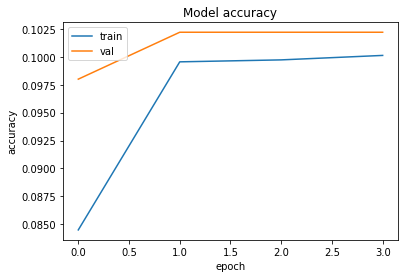

In [9]:

# Create the model
model = cnn_model(x_train.shape[1:], 10)

# Train the model
ret1 = train_model(model, x_train, y_train, batch_size= 32)


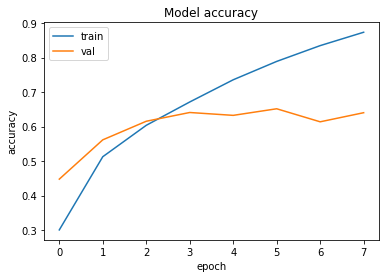

In [11]:
######################
# TO DO

# Plot the evolution of (train/val) accuracy through epochs
plt.plot(ret1.history['accuracy'])
plt.plot(ret1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# END TO DO 
######################

A confusion matrix is often used in supervised learning to understand how well (or not) each category is being classified.  Each element (i,j) in the confusion matrix represents the predicted class j for each true class i.  Consider the following 10 predictions for a 2 category model predicting male or female.

| example     | true category  | predicted category  |
|-------------|----------------|---------------------|
| 1           | male           | male                |
| 2           | female         | male                |
| 3           | female         | female              |
| 4           | male           | male                |
| 5           | male           | female              |
| 6           | male           | male                |
| 7           | female         | female              |
| 8           | male           | female              |
| 9           | female         | female              |
| 10          | female         | female              |

Based on the above data, the model is accurate 70% of the time.  The confusion matrix is

|        | predicted male | predicted female |
|--------|------|--------|
| true male   | 3    | 2      |
| true female | 1    | 4      |

The confusion matrix gives us more information than a simple accuracy measurement. 

**19) Create the confusion matrix the CIFAR-10 dataset using the test data.  What does it tell you about the relationships between each class?**

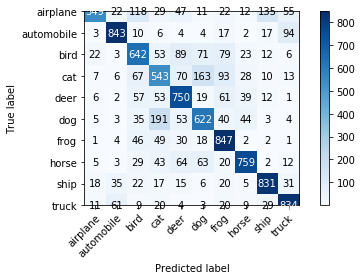

In [30]:
######################
# TO DO

import sklearn.metrics as metrics

y_pred_one = model.predict(x_test)  # shape=(n_samples, 12)
y_pred = np.argmax(y_pred_one, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)
y_true = np.argmax(y_test, axis=1)

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = ''

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    #if normalize:
    #    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #    print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max()/2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=False,
                      title='')

plt.show()

# END TO DO 
######################

<a id='pretrained_cnn'></a>
# 4 - Pretrained Networks

Note that several pre-trained networks are directly accessible via keras (see https://nbviewer.jupyter.org/github/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb)

**20) Build a classifier with a better accuracy on the test set than all CNN you have built before. One rule only: do not use CNN pretrained on CIFAR10.** 

In [31]:
###########################
# TO DO 

#Import the architecture and the weights of VGG16

from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',include_top=False)

# Extract the features from the last layer of VGG16 (we have removed the dense layers)

u = conv_base.predict(x_train)
input_dim = np.prod(u.shape[1:])
x_train_flat = np.reshape(u, (u.shape[0],input_dim) )

u = conv_base.predict(x_test)
x_test_flat = np.reshape(u, (u.shape[0], input_dim ) )

# END TO DO 
##################

In [44]:
###########################
# TO DO 

#Create a network to predict based on the extracted features

from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=input_dim))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train_flat, y_train,
                    epochs=10,
                    batch_size=32, validation_split=0.2)

# END TO DO 
##################

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - ETA: 19s - loss: 0.3643 - accuracy: 0.900 - ETA: 8s - loss: 0.3458 - accuracy: 0.899 - ETA: 6s - loss: 0.3460 - accuracy: 0.89 - ETA: 6s - loss: 0.3487 - accuracy: 0.89 - ETA: 5s - loss: 0.3475 - accuracy: 0.89 - ETA: 5s - loss: 0.3453 - accuracy: 0.89 - ETA: 4s - loss: 0.3441 - accuracy: 0.89 - ETA: 4s - loss: 0.3431 - accuracy: 0.89 - ETA: 4s - loss: 0.3434 - accuracy: 0.89 - ETA: 4s - loss: 0.3430 - accuracy: 0.89 - ETA: 4s - loss: 0.3425 - accuracy: 0.89 - ETA: 4s - loss: 0.3420 - accuracy: 0.89 - ETA: 4s - loss: 0.3414 - accuracy: 0.89 - ETA: 4s - loss: 0.3406 - accuracy: 0.89 - ETA: 4s - loss: 0.3399 - accuracy: 0.89 - ETA: 4s - loss: 0.3398 - accuracy: 0.89 - ETA: 4s - loss: 0.3395 - accuracy: 0.89 - ETA: 4s - loss: 0.3390 - accuracy: 0.89 - ETA: 4s - loss: 0.3382 - accuracy: 0.89 - ETA: 4s - loss: 0.3376 - accuracy: 0.89 - ETA: 4s - loss: 0.3368 - accuracy: 0.89 - ETA: 4s

40000/40000 [==============================] - ETA: 0s - loss: 0.2374 - accuracy: 0.90 - ETA: 4s - loss: 0.2527 - accuracy: 0.90 - ETA: 3s - loss: 0.2522 - accuracy: 0.90 - ETA: 3s - loss: 0.2547 - accuracy: 0.90 - ETA: 3s - loss: 0.2553 - accuracy: 0.90 - ETA: 3s - loss: 0.2557 - accuracy: 0.90 - ETA: 2s - loss: 0.2543 - accuracy: 0.90 - ETA: 2s - loss: 0.2540 - accuracy: 0.90 - ETA: 2s - loss: 0.2541 - accuracy: 0.90 - ETA: 2s - loss: 0.2541 - accuracy: 0.90 - ETA: 2s - loss: 0.2539 - accuracy: 0.90 - ETA: 2s - loss: 0.2537 - accuracy: 0.90 - ETA: 2s - loss: 0.2543 - accuracy: 0.90 - ETA: 2s - loss: 0.2542 - accuracy: 0.90 - ETA: 2s - loss: 0.2544 - accuracy: 0.90 - ETA: 2s - loss: 0.2541 - accuracy: 0.90 - ETA: 2s - loss: 0.2539 - accuracy: 0.90 - ETA: 2s - loss: 0.2540 - accuracy: 0.90 - ETA: 2s - loss: 0.2538 - accuracy: 0.90 - ETA: 2s - loss: 0.2537 - accuracy: 0.90 - ETA: 2s - loss: 0.2537 - accuracy: 0.90 - ETA: 2s - loss: 0.2537 - accuracy: 0.90 - ETA: 2s - loss: 0.2534 - accu

40000/40000 [==============================] - ETA: 0s - loss: 0.2263 - accuracy: 0.92 - ETA: 3s - loss: 0.2354 - accuracy: 0.91 - ETA: 3s - loss: 0.2343 - accuracy: 0.91 - ETA: 3s - loss: 0.2348 - accuracy: 0.91 - ETA: 3s - loss: 0.2350 - accuracy: 0.91 - ETA: 3s - loss: 0.2357 - accuracy: 0.91 - ETA: 3s - loss: 0.2353 - accuracy: 0.91 - ETA: 3s - loss: 0.2368 - accuracy: 0.91 - ETA: 3s - loss: 0.2357 - accuracy: 0.91 - ETA: 3s - loss: 0.2359 - accuracy: 0.91 - ETA: 3s - loss: 0.2357 - accuracy: 0.91 - ETA: 3s - loss: 0.2354 - accuracy: 0.91 - ETA: 3s - loss: 0.2357 - accuracy: 0.91 - ETA: 3s - loss: 0.2359 - accuracy: 0.91 - ETA: 3s - loss: 0.2355 - accuracy: 0.91 - ETA: 3s - loss: 0.2354 - accuracy: 0.91 - ETA: 3s - loss: 0.2358 - accuracy: 0.91 - ETA: 2s - loss: 0.2355 - accuracy: 0.91 - ETA: 2s - loss: 0.2355 - accuracy: 0.91 - ETA: 2s - loss: 0.2354 - accuracy: 0.91 - ETA: 2s - loss: 0.2356 - accuracy: 0.91 - ETA: 2s - loss: 0.2353 - accuracy: 0.91 - ETA: 2s - loss: 0.2353 - accu

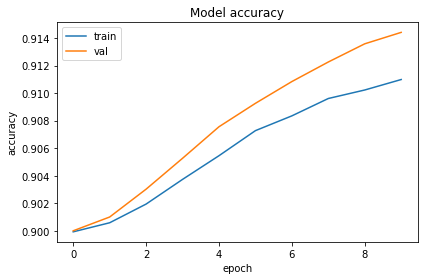

In [45]:
###########################
# TO DO 

# Plot the evolution of (train/val) accuracy through epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# END TO DO 
##################

The accuracy on the test set is 0.5077
The prediction for this image is frog but it is in reality a frog
[1045. 1183.  659.  971.  969.  924. 1151. 1049. 1122.  927.]
[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]


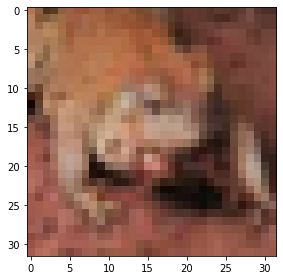

In [46]:
##################
# TO DO 

#Compute the predictions
y_pred = model.predict_classes(x_test_flat)
y_pred = to_categorical(y_pred, 10)

# Compute the accuracy
print("The accuracy on the test set is", metrics.accuracy_score(y_test, y_pred) )

# Plot image number j 
j= 5
plt.imshow(x_test[j])
print("The prediction for this image is", labels[np.argmax(y_pred[j])], "but it is in reality a", labels[np.argmax(y_test[j])])

#Here is the distribution of predictions : if an element is close to one, 
#the algorithm almost always predict this category

print(y_pred.sum(axis=0))
print(y_test.sum(axis=0))


# END TO DO 
##################